## Setup

In [1]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
import model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
sim['location']

,patient,date,latitude,longitude
0,0,0,-58.435613,-34.545653
1,0,1,-58.437731,-34.549600
2,0,2,-58.435019,-34.548340
3,0,3,-58.441275,-34.547083
4,0,4,-58.438393,-34.546874
...,...,...,...,...
199995,999,195,-58.436357,-34.547459
199996,999,196,-58.436041,-34.550704
199997,999,197,-58.435033,-34.550585
199998,999,198,-58.430957,-34.547878


In [3]:
sim['contacts']

,date,patient1,patient2,distance
0,0,0,74,0.003459
1,0,0,216,0.003762
2,0,0,274,0.005272
3,0,0,311,0.000000
4,0,0,783,0.002629
...,...,...,...,...
560710,199,949,954,0.003819
560711,199,949,994,0.005120
560712,199,962,988,0.005199
560713,199,965,998,0.004545


In [9]:
import pandas as pd
negative_tests = sim['tests'].loc[np.logical_not(sim['tests']['result'])][['patient', 'date']]
negative_tests['outcome'] = 'negative'
positive_tests = sim['tests'].loc[sim['tests']['result']][['patient', 'date']]
positive_tests['outcome'] = 'positive'
hospital = sim['hospital'].copy()
hospital['outcome'] = 'hospital'
deaths = sim['deaths'].copy()
deaths['outcome'] = 'dead'
outcomes = pd.concat([positive_tests, negative_tests, hospital, deaths])
outcomes

,patient,date,outcome
5,204,2,positive
9,807,2,positive
2,119,4,positive
8,455,4,positive
9,509,4,positive
...,...,...,...
0,127,101,dead
6,904,121,dead
5,773,172,dead
2,226,175,dead


In [12]:
from joblib import Parallel, delayed

def calculate_centrality(p, contacts):
    return np.sum([np.logical_or(contacts['patient1'] == p, contacts['patient2']==p)])

centrality = np.array(Parallel(10)(delayed(calculate_centrality)(p, sim['contacts'])
                       for p in sim['patients']['patient']))

## Data Generation

In [2]:
try:
    sim = model.sim.load_pickle()
except FileNotFoundError:
    sim = model.sim.simulate(shapefile=os.path.join("..", "..", "data", "ba_comunas"), N0=1000, T=200, 
                         N_infected=1, step_fraction=40, distance_cutoff=0.006, seed=38)

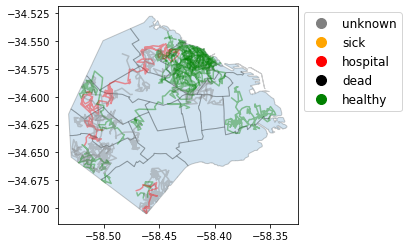

<Figure size 432x288 with 0 Axes>

In [35]:
model.sim.plot_sim(sim, patients = np.arange(10), color='known_status')
plt.savefig("sample_known_status.png")

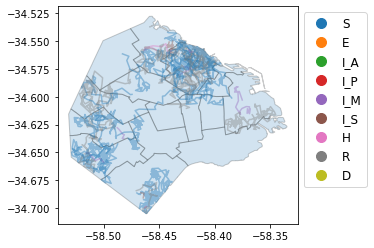

<Figure size 432x288 with 0 Axes>

In [36]:
model.sim.plot_sim(sim, patients = np.arange(10), color='state')
plt.savefig("sample_true_state.png")

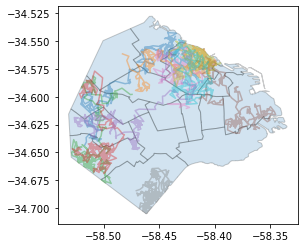

<Figure size 432x288 with 0 Axes>

In [37]:
model.sim.plot_sim(sim, patients = np.arange(10), color='patient')
plt.savefig("sample_patient_id.png")

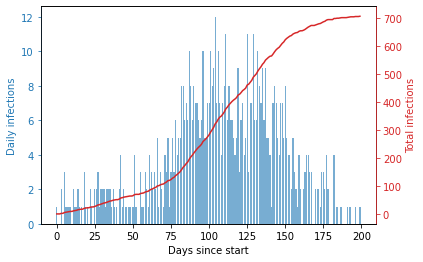

In [38]:
model.sim.plot_infections(sim)
plt.savefig("infection_rate.png")

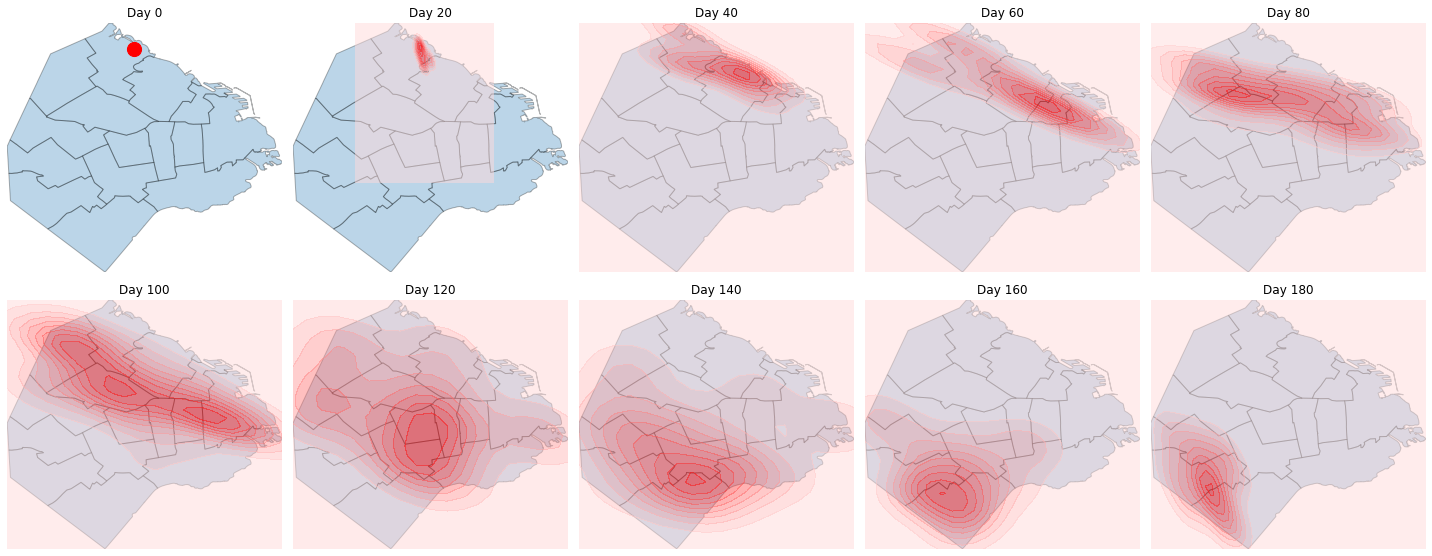

In [39]:
model.sim.plot_heatmap(sim)
plt.savefig("infectious_population_density.png")

In [15]:
sim['location'].head()

,patient,date,latitude,longitude
0,0,0,-58.435613,-34.545653
1,0,1,-58.437731,-34.549600
2,0,2,-58.435019,-34.548340
3,0,3,-58.441275,-34.547083
4,0,4,-58.438393,-34.546874


In [16]:
sim['tests'].head()

,patient,date,result
0,0,0,False
1,74,0,False
2,311,0,False
3,455,0,False
0,0,1,False


In [17]:
sim['hospital'].head()

,patient,date
19,509,9
0,0,28
43,928,40
18,504,72
33,769,73


In [18]:
sim['deaths'].head()

,patient,date
4,509,10
3,504,80
7,928,88
0,127,101
6,904,121


In [43]:
model.sim.io.save_pickle(sim)
model.sim.io.save_csv(sim)

## Disease spread modeling

For model specification, see the [README](../../README.md)

In [14]:
# set the initial state -- at present everyone is probably healthy
state = model.model.initial_state(sim)
state

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# evaluate contacts each day and update the model
curr_date = 70
save_states = np.array([0, 1, 5, 10])
saved_states = {}
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, distance_cutoff=0.006)
    if date in save_states + curr_date:
        saved_states[date - curr_date] = state

In [22]:
output = pd.DataFrame({'centrality':centrality})
for i in save_states:
    for j, name in model.model.STATES.items():
        output["{}_{}".format(name, i)] = saved_states[i][:,j]

In [23]:
output

,centrality,S_0,E_0,I_A_0,I_P_0,I_M_0,I_S_0,H_0,R_0,D_0,...,D_5,S_10,E_10,I_A_10,I_P_10,I_M_10,I_S_10,H_10,R_10,D_10
0,1316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037840,0.769728,0.192432,...,0.194875,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017353,0.786118,0.196529
1,1035,0.243854,0.021254,0.010124,0.001835,0.014020,0.001071,0.006731,0.693890,0.007222,...,0.007681,0.218415,0.001472,0.012617,0.000625,0.019216,0.001813,0.004653,0.733134,0.008056
2,960,0.311017,0.100794,0.017815,0.004407,0.023432,0.002121,0.005741,0.529275,0.005398,...,0.005821,0.056612,0.307475,0.013296,0.002185,0.018649,0.001631,0.005176,0.588750,0.006226
3,1113,0.387209,0.000380,0.011913,0.002113,0.016545,0.001298,0.007234,0.567708,0.005600,...,0.006097,0.293740,0.057121,0.009942,0.001921,0.013642,0.001163,0.005051,0.610910,0.006508
4,1177,0.271630,0.063462,0.016937,0.003259,0.023254,0.002059,0.006297,0.606859,0.006243,...,0.006697,0.297075,0.008739,0.009559,0.001387,0.013600,0.001142,0.004871,0.656527,0.007100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1053,0.284772,0.082678,0.015632,0.004828,0.019553,0.001722,0.005790,0.579033,0.005991,...,0.006410,0.271206,0.051102,0.012207,0.002020,0.017106,0.001495,0.004968,0.633098,0.006799
996,1220,0.134151,0.174830,0.024429,0.000751,0.037689,0.003474,0.008146,0.610576,0.005953,...,0.006555,0.205634,0.026506,0.022818,0.007842,0.027706,0.002460,0.007231,0.692683,0.007119
997,1132,0.000000,0.000000,0.000000,0.000000,0.089067,0.005726,0.044595,0.850677,0.009936,...,0.012931,0.000000,0.000000,0.000000,0.000000,0.019056,0.000851,0.023576,0.941403,0.015115
998,1123,0.413335,0.038315,0.017524,0.003921,0.023484,0.002057,0.006533,0.490047,0.004784,...,0.005254,0.290476,0.078420,0.023766,0.008807,0.028185,0.002606,0.005926,0.556124,0.005691


In [20]:
sim['location'].to_csv("location.csv")
sim['contacts'].to_csv("contacts.csv")
outcomes.to_csv("outcomes.csv")
output.to_csv

{0: 'S',
 1: 'E',
 2: 'I_A',
 3: 'I_P',
 4: 'I_M',
 5: 'I_S',
 6: 'H',
 7: 'R',
 8: 'D'}

In [68]:
# print the final model state
with np.printoptions(threshold=np.inf):
    print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.    0.8   0.2  ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.003 0.    0.01  0.969 0.018]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.166 0.667 0.167]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.001 0.979 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.    0.    0.    0.    0.    0.    0.014 0.789 0.197]
 [0.    0.    0.    0.    0.   

In [69]:
np.argmax(state, axis=1)

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 7, 7, 8, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7,
       7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [70]:
sim['states'][:,-1]

array([7., 7., 7., 7., 0., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 0.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7.,
       5., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 0., 7.,
       7., 7., 7., 0., 0., 7., 7., 7., 0., 0., 7., 7., 7., 0., 7., 7., 7.,
       0., 0., 7., 7., 7., 7., 0., 0., 0., 7., 7., 7., 0., 7., 7., 4., 7.,
       7., 0., 7., 7., 0., 7., 7., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 8., 0., 0., 8., 7., 7., 0., 7., 7.,
       0., 7., 7., 7., 0., 7., 0., 7., 7., 7., 0., 7., 7., 0., 7., 7., 0.,
       7., 7., 0., 7., 2., 7., 0., 7., 0., 0., 0., 7., 7., 0., 0., 7., 0.,
       0., 7., 7., 7., 0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       0., 0., 7., 0., 7., 0., 7., 0., 7., 7., 7., 7., 7., 7., 0., 0., 7.,
       7., 7., 7., 7., 7., 7., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 0., 7., 7.